<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 126.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=d303c25656dca43ad17e4b074430ff0ec6eedd1809235bfb86342cd618b8a3ad
  Stored in directory

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders

from model_container import ModelContainer



Mounted at /content/gdrive


In [6]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



KeyboardInterrupt: ignored

In [ ]:
sorted(val_df.label.unique())

[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]

In [ ]:
# Different combinations to evaluate
models = [CustomResNet50, CustomResNet50b, CustomDenseNet]
loss_funcs = [nn.CrossEntropyLoss, FocalLoss]
loaders = [dataloaders, dataloaders2]
optimizers = ['SGD', 'Adam']
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}


In [ ]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}


Training with CustomResNet50, SGD, CrossEntropyLoss


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 430MB/s]


Epoch 0/14
----------
train Loss: 1.9938 Acc: 0.4156
val Loss: 1.2903 Acc: 0.6525

Epoch 1/14
----------
train Loss: 0.9359 Acc: 0.7465
val Loss: 0.8453 Acc: 0.7599

Epoch 2/14
----------
train Loss: 0.5517 Acc: 0.8473
val Loss: 0.7380 Acc: 0.7853

Epoch 3/14
----------
train Loss: 0.3480 Acc: 0.9058
val Loss: 0.6654 Acc: 0.7938

Epoch 4/14
----------
train Loss: 0.2399 Acc: 0.9416
val Loss: 0.6128 Acc: 0.7994

Epoch 5/14
----------
train Loss: 0.1689 Acc: 0.9642
val Loss: 0.6167 Acc: 0.8249

Epoch 6/14
----------
train Loss: 0.1067 Acc: 0.9810
val Loss: 0.5683 Acc: 0.8220

Epoch 7/14
----------
train Loss: 0.0754 Acc: 0.9927
val Loss: 0.5974 Acc: 0.8305

Epoch 8/14
----------
train Loss: 0.0719 Acc: 0.9905
val Loss: 0.5774 Acc: 0.8249

Epoch 9/14
----------
train Loss: 0.0676 Acc: 0.9905
val Loss: 0.5916 Acc: 0.8220

Epoch 10/14
----------
train Loss: 0.0654 Acc: 0.9927
val Loss: 0.5846 Acc: 0.8192

Epoch 11/14
----------
train Loss: 0.0712 Acc: 0.9912
val Loss: 0.6047 Acc: 0.8277

Ep

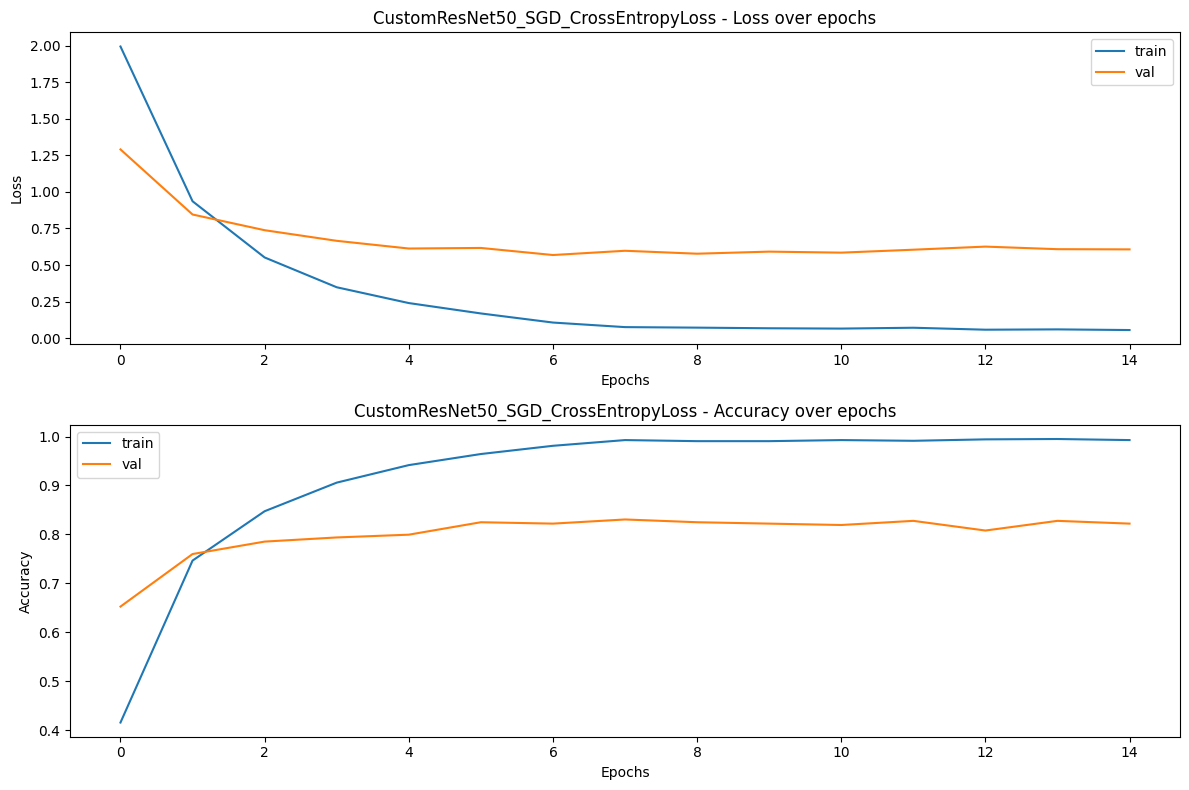


Training with CustomResNet50, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.5184 Acc: 0.4229
val Loss: 0.8080 Acc: 0.6384

Epoch 1/14
----------
train Loss: 0.5219 Acc: 0.7597
val Loss: 0.5323 Acc: 0.7458

Epoch 2/14
----------
train Loss: 0.2881 Acc: 0.8656
val Loss: 0.4715 Acc: 0.7627

Epoch 3/14
----------
train Loss: 0.1648 Acc: 0.9218
val Loss: 0.4208 Acc: 0.7994

Epoch 4/14
----------
train Loss: 0.1126 Acc: 0.9445
val Loss: 0.3606 Acc: 0.8051

Epoch 5/14
----------
train Loss: 0.0743 Acc: 0.9642
val Loss: 0.4379 Acc: 0.7684

Epoch 6/14
----------
train Loss: 0.0445 Acc: 0.9854
val Loss: 0.3339 Acc: 0.8277

Epoch 7/14
----------
train Loss: 0.0330 Acc: 0.9905
val Loss: 0.3352 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.0305 Acc: 0.9934
val Loss: 0.3405 Acc: 0.8277

Epoch 9/14
----------
train Loss: 0.0296 Acc: 0.9898
val Loss: 0.3496 Acc: 0.8136

Epoch 10/14
----------
train Loss: 0.0276 Acc: 0.9920
val Loss: 0.3502 Acc: 0.8051

Epoch 11/14
----------
train Loss: 0.024

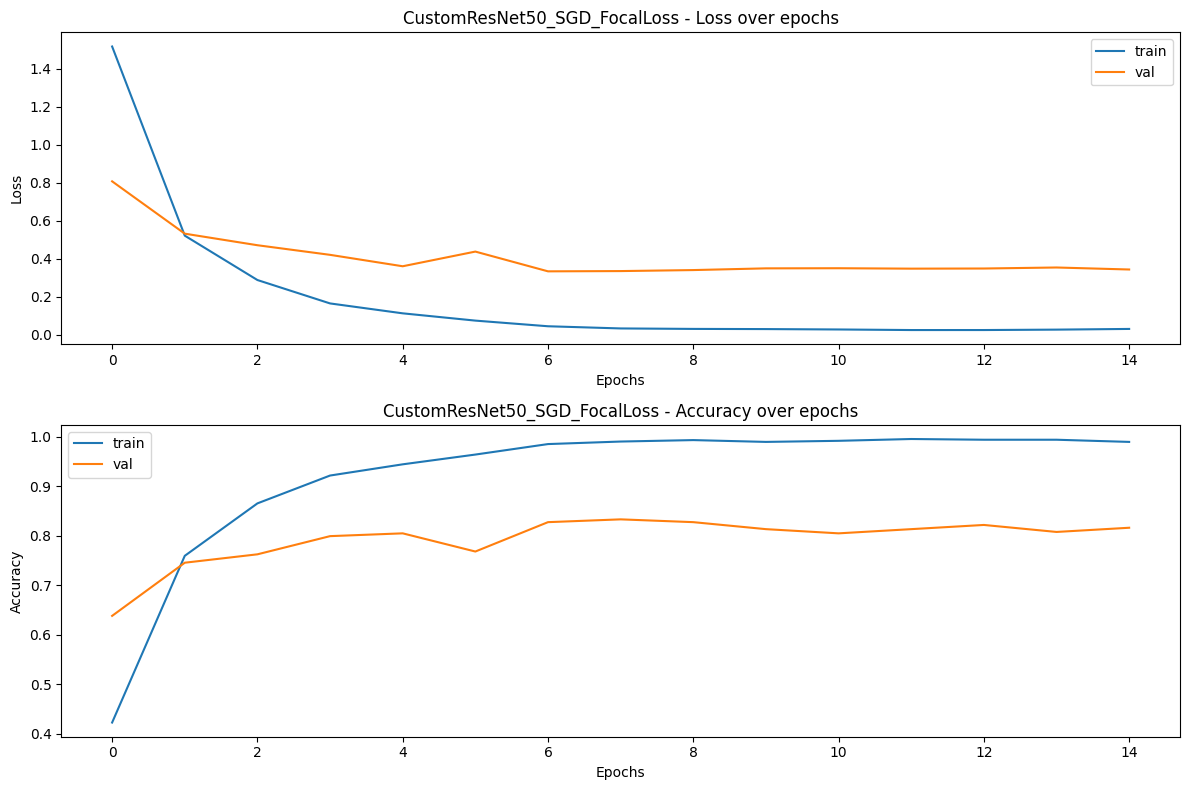


Training with CustomResNet50b, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5157 Acc: 0.2272
val Loss: 2.1157 Acc: 0.3220

Epoch 1/14
----------
train Loss: 1.7305 Acc: 0.4843
val Loss: 1.3713 Acc: 0.6017

Epoch 2/14
----------
train Loss: 1.1020 Acc: 0.6947
val Loss: 1.0248 Acc: 0.6864

Epoch 3/14
----------
train Loss: 0.7355 Acc: 0.7882
val Loss: 0.8004 Acc: 0.7345

Epoch 4/14
----------
train Loss: 0.5283 Acc: 0.8473
val Loss: 0.6875 Acc: 0.8023

Epoch 5/14
----------
train Loss: 0.3966 Acc: 0.8817
val Loss: 0.6506 Acc: 0.7853

Epoch 6/14
----------
train Loss: 0.2839 Acc: 0.9189
val Loss: 0.6540 Acc: 0.7994

Epoch 7/14
----------
train Loss: 0.2111 Acc: 0.9511
val Loss: 0.5971 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.1962 Acc: 0.9503
val Loss: 0.5913 Acc: 0.8164

Epoch 9/14
----------
train Loss: 0.1947 Acc: 0.9554
val Loss: 0.5952 Acc: 0.8164

Epoch 10/14
----------
train Loss: 0.1891 Acc: 0.9540
val Loss: 0.6054 Acc: 0.8107

Epoch 11/14
----------
train Los

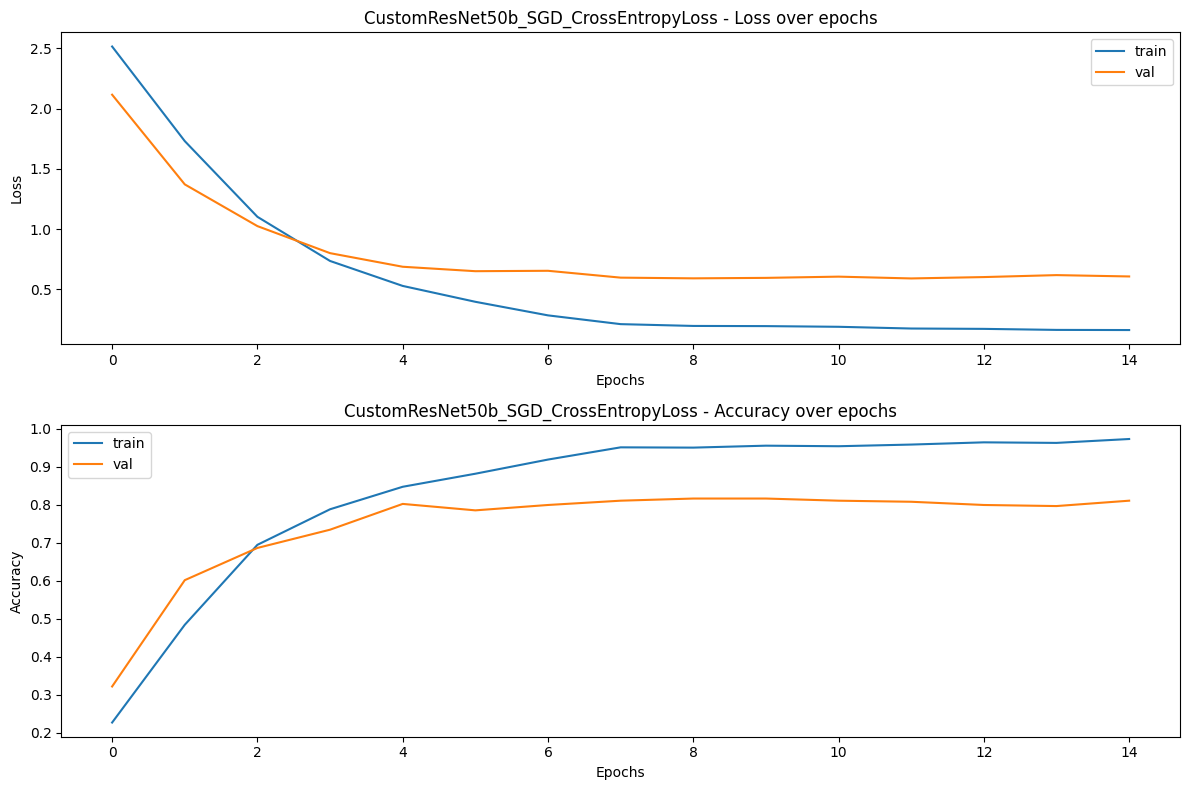


Training with CustomResNet50b, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.0946 Acc: 0.2447
val Loss: 1.5714 Acc: 0.4322

Epoch 1/14
----------
train Loss: 1.1488 Acc: 0.5457
val Loss: 0.8414 Acc: 0.6215

Epoch 2/14
----------
train Loss: 0.5857 Acc: 0.7305
val Loss: 0.5927 Acc: 0.7260

Epoch 3/14
----------
train Loss: 0.3674 Acc: 0.8247
val Loss: 0.5055 Acc: 0.7627

Epoch 4/14
----------
train Loss: 0.2596 Acc: 0.8678
val Loss: 0.5022 Acc: 0.7458

Epoch 5/14
----------
train Loss: 0.1709 Acc: 0.9050
val Loss: 0.4158 Acc: 0.7740

Epoch 6/14
----------
train Loss: 0.1305 Acc: 0.9335
val Loss: 0.4790 Acc: 0.7542

Epoch 7/14
----------
train Loss: 0.0986 Acc: 0.9445
val Loss: 0.4364 Acc: 0.7938

Epoch 8/14
----------
train Loss: 0.0842 Acc: 0.9715
val Loss: 0.4107 Acc: 0.7966

Epoch 9/14
----------
train Loss: 0.0806 Acc: 0.9686
val Loss: 0.4111 Acc: 0.8023

Epoch 10/14
----------
train Loss: 0.0768 Acc: 0.9701
val Loss: 0.4196 Acc: 0.7966

Epoch 11/14
----------
train Loss: 0.08

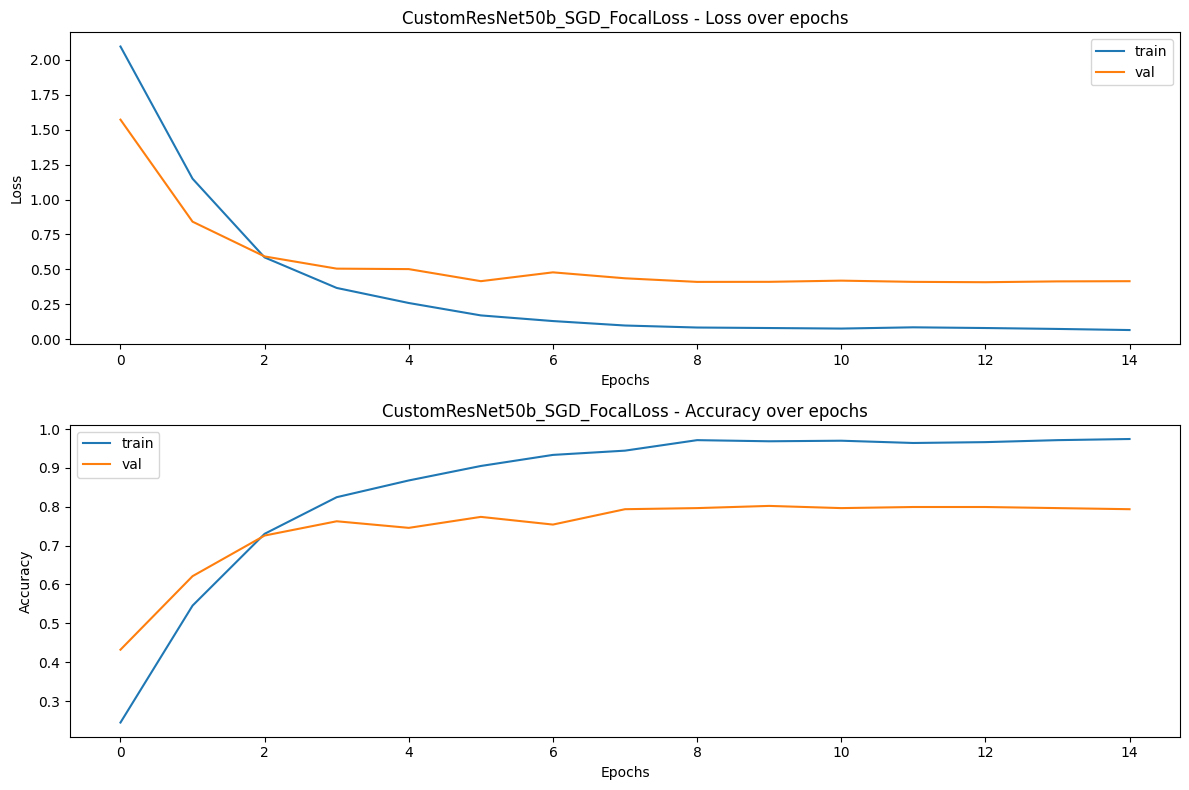

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Training with CustomDenseNet, SGD, CrossEntropyLoss


100%|██████████| 30.8M/30.8M [00:00<00:00, 388MB/s]


Epoch 0/14
----------
train Loss: 1.8650 Acc: 0.4690
val Loss: 1.1530 Acc: 0.6610

Epoch 1/14
----------
train Loss: 0.8210 Acc: 0.7692
val Loss: 0.8156 Acc: 0.7288

Epoch 2/14
----------
train Loss: 0.5249 Acc: 0.8466
val Loss: 0.6553 Acc: 0.7797

Epoch 3/14
----------
train Loss: 0.3477 Acc: 0.9218
val Loss: 0.6170 Acc: 0.7966

Epoch 4/14
----------
train Loss: 0.2302 Acc: 0.9481
val Loss: 0.5601 Acc: 0.8107

Epoch 5/14
----------
train Loss: 0.1477 Acc: 0.9715
val Loss: 0.5602 Acc: 0.8136

Epoch 6/14
----------
train Loss: 0.1220 Acc: 0.9781
val Loss: 0.5499 Acc: 0.8220

Epoch 7/14
----------
train Loss: 0.0829 Acc: 0.9927
val Loss: 0.5423 Acc: 0.8277

Epoch 8/14
----------
train Loss: 0.0752 Acc: 0.9905
val Loss: 0.5692 Acc: 0.8220

Epoch 9/14
----------
train Loss: 0.0674 Acc: 0.9920
val Loss: 0.5262 Acc: 0.8362

Epoch 10/14
----------
train Loss: 0.0702 Acc: 0.9927
val Loss: 0.5710 Acc: 0.8107

Epoch 11/14
----------
train Loss: 0.0670 Acc: 0.9949
val Loss: 0.5344 Acc: 0.8362

Ep

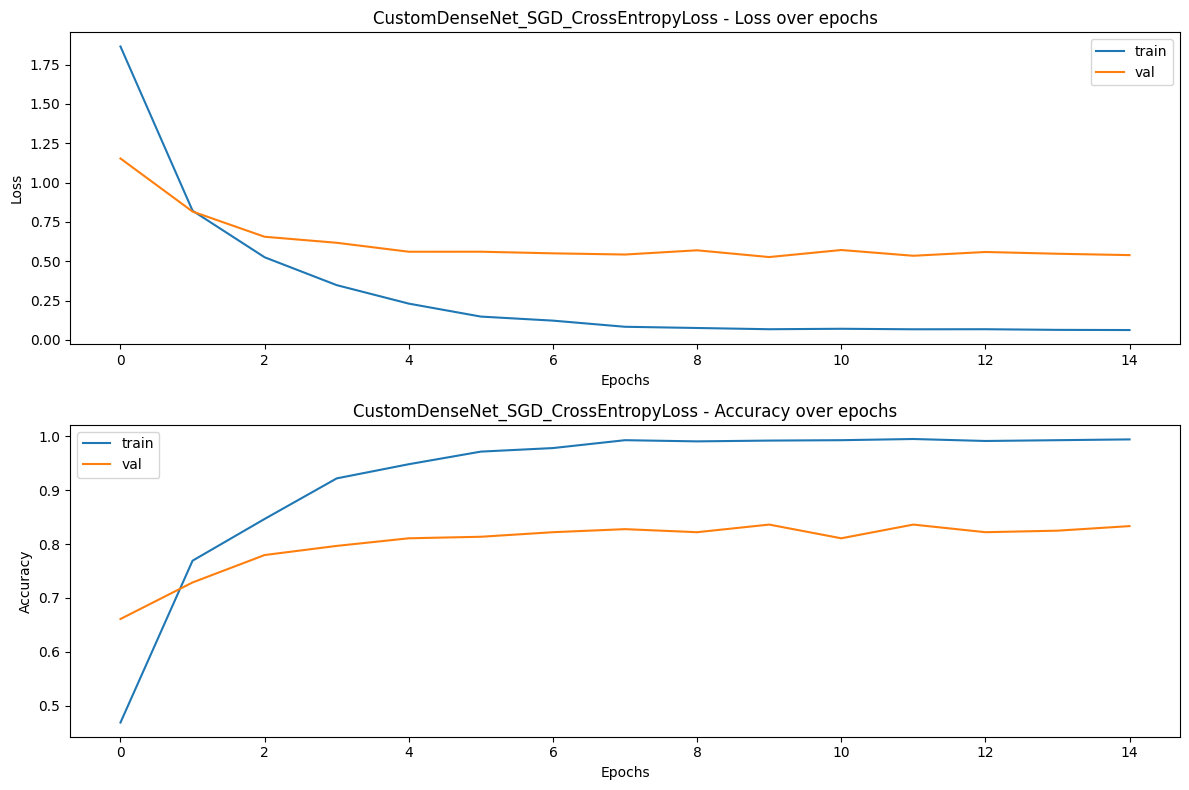


Training with CustomDenseNet, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.3694 Acc: 0.4872
val Loss: 0.7457 Acc: 0.6695

Epoch 1/14
----------
train Loss: 0.4460 Acc: 0.8079
val Loss: 0.5032 Acc: 0.7373

Epoch 2/14
----------
train Loss: 0.2442 Acc: 0.8780
val Loss: 0.4289 Acc: 0.7966

Epoch 3/14
----------
train Loss: 0.1556 Acc: 0.9182
val Loss: 0.3823 Acc: 0.7994

Epoch 4/14
----------
train Loss: 0.1005 Acc: 0.9547
val Loss: 0.3567 Acc: 0.8079

Epoch 5/14
----------
train Loss: 0.0552 Acc: 0.9788
val Loss: 0.3474 Acc: 0.8192

Epoch 6/14
----------
train Loss: 0.0390 Acc: 0.9905
val Loss: 0.3603 Acc: 0.8107

Epoch 7/14
----------
train Loss: 0.0364 Acc: 0.9883
val Loss: 0.3524 Acc: 0.8079

Epoch 8/14
----------
train Loss: 0.0337 Acc: 0.9890
val Loss: 0.3464 Acc: 0.8192

Epoch 9/14
----------
train Loss: 0.0294 Acc: 0.9920
val Loss: 0.3538 Acc: 0.8136

Epoch 10/14
----------
train Loss: 0.0248 Acc: 0.9956
val Loss: 0.3333 Acc: 0.8136

Epoch 11/14
----------
train Loss: 0.023

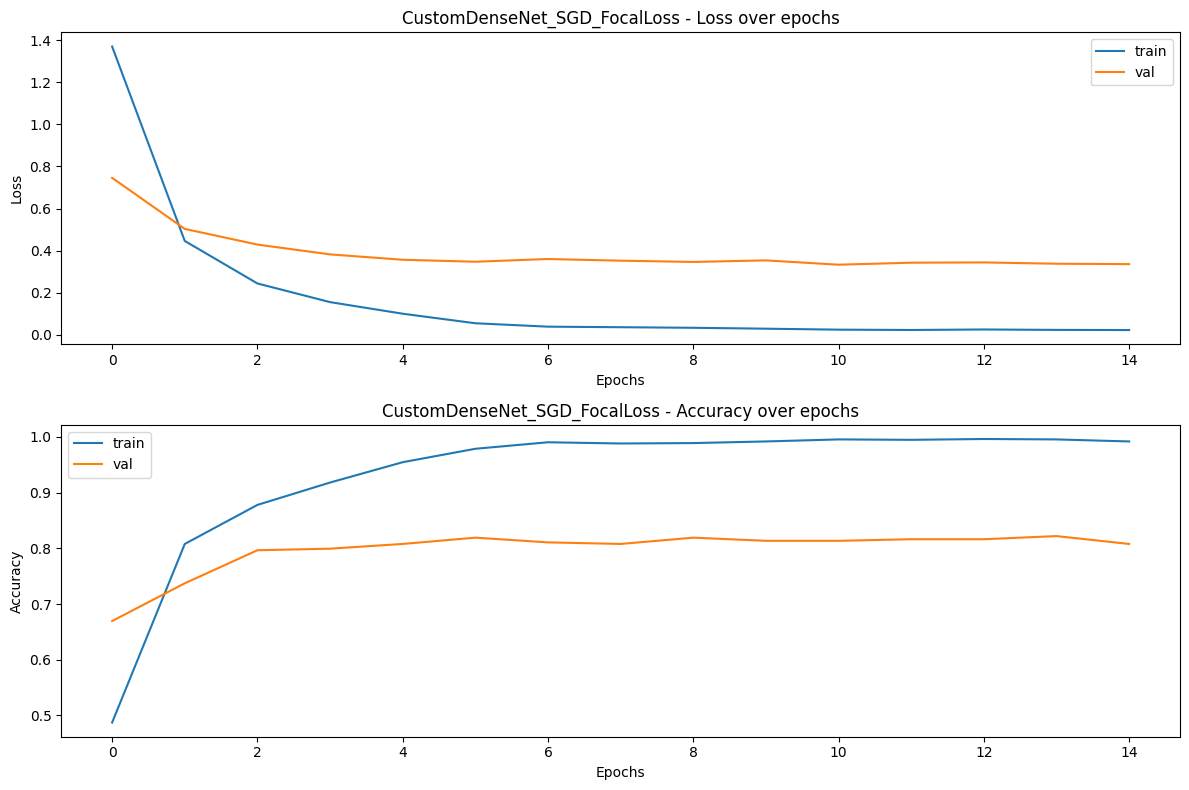

In [ ]:
# perform several training runs to compare accuracy on the validation dataset

for model_class in models:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {opt_class.__name__}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{opt_class.__name__}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

               

In [ ]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("../assets/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.73      0.73      0.73        49
           6       0.87      0.93      0.90        14
           7       0.94      0.94      0.94        18
           8       0.92      1.00      0.96        35
           9       1.00      0.94      0.97        34
          11       1.00      0.90      0.95        20
          12       0.00      0.00      0.00        12
          13       1.00      0.33      0.50         3
          14       0.94      0.84      0.89        19
          16       0.42      0.55      0.48        20
          17       0.94      0.94      0.94        17
          18       0.95      0.95      0.95        22
          19       1.00      0.79      0.88        19
          23       0.47      0.42      0.44        19
          25       0.67   

FileNotFoundError: ignored

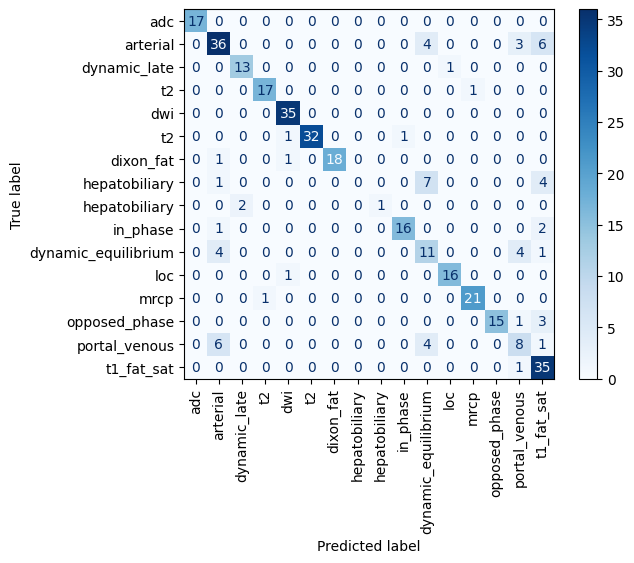

<Figure size 2500x2500 with 0 Axes>

In [ ]:
# Evaluate the model on the val dataset

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(val_predictions, val_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), save_filename)



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)
